### ConvLSTM NDVI forecasting using NDVI and LST
- 3 input (3 NDVI and 3 LST) with 3 output (3 NDVI) (distinct timestep)
- NDVI:
  - sourse: MODIS/061/MOD13A2
  - resolution 1km
  - image: 84x65 pixel
- LAI:
  - source: MODIS/061/MOD15A2H
  - interval: 16 days (by default 8-days)
  - resolution 1km (by default 500m)
  - image: 84x65 pixel

In [1]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 18.6 MB/s eta 0:00:00


In [3]:
import rasterio
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
from sklearn.preprocessing import MinMaxScaler

### Preparing NDVI data

In [5]:
ndvi_path = './NDVI-data-65x84'
ndvi_tif_files = glob.glob(ndvi_path+"/*.tif")

ndvi_tif_files.sort()
len(ndvi_tif_files)

526

In [50]:
ndvi_tif_files[:4]

['./NDVI-data-65x84/2000_02_18.tif',
 './NDVI-data-65x84/2000_03_05.tif',
 './NDVI-data-65x84/2000_03_21.tif',
 './NDVI-data-65x84/2000_04_06.tif']

In [45]:
ndvi_tif_files[518]

'./NDVI-data-65x84/2022_08_29.tif'

In [6]:
ndvi_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in ndvi_tif_files]

print(ndvi_data_dates[-5:])
print('\n', len(ndvi_data_dates))

## date indexing

periods = [period for period in range(0, len(ndvi_data_dates), 6)]
ndvi_dataset_dates = []
for i in range(len(ndvi_data_dates)-5):
  period_date = []
  for date in ndvi_data_dates[i:i+6]:
    period_date.append(date)
  period_date_arr = np.array(period_date)
  ndvi_dataset_dates.append(period_date_arr)

['2022_10_16', '2022_11_01', '2022_11_17', '2022_12_03', '2022_12_19']

 526


In [51]:
ndvi_dataset_dates[0]

array(['2000_02_18', '2000_03_05', '2000_03_21', '2000_04_06',
       '2000_04_22', '2000_05_08'], dtype='<U10')

In [ ]:
ndvi_dataset_dates[-2]

array(['2022_09_14', '2022_09_30', '2022_10_16', '2022_11_01',
       '2022_11_17', '2022_12_03'], dtype='<U10')

In [7]:
ndvi_dataset_dates_arr = np.array(ndvi_dataset_dates[:518])

In [52]:
ndvi_dataset_dates_arr[0]

array(['2000_02_18', '2000_03_05', '2000_03_21', '2000_04_06',
       '2000_04_22', '2000_05_08'], dtype='<U10')

In [8]:
crs_list = []
transform_list = []

periods = [period for period in range(0, len(ndvi_tif_files), 6)]
ndvi_dataset = []
for i in range(len(ndvi_tif_files)-5):
  period_data = []
  for file_ in ndvi_tif_files[i:i+6]:
    ndvi_data = rasterio.open(file_)
    ndvi_data_arr = ndvi_data.read(1)
    ndvi_data_crs = ndvi_data.crs  # Get the coordinate reference system (CRS)
    crs_list.append(ndvi_data_crs)
    ndvi_data_transform = ndvi_data.transform # Get the transformation matrix
    transform_list.append(ndvi_data_transform)
    period_data.append(ndvi_data_arr)
  period_data_arr = np.array(period_data)
  ndvi_dataset.append(period_data_arr)

In [ ]:
len(ndvi_dataset)

521

In [9]:
ndvi_dataset_arr = np.array(ndvi_dataset[:518])
ndvi_dataset_arr.shape

(518, 6, 84, 65)

In [10]:
samples = ndvi_dataset_arr.shape[0]
time_steps = ndvi_dataset_arr.shape[1]
height, width = ndvi_dataset_arr.shape[2], ndvi_dataset_arr.shape[3]
channels = 1

ndvi_data_raw = ndvi_dataset_arr.reshape(samples, time_steps, height, width, channels)

In [11]:
# Normalize NDVI values to range [0, 1]
ndvi_scaler = MinMaxScaler()
normalized_ndvi_data = ndvi_scaler.fit_transform(ndvi_data_raw.reshape(-1, 1))
ndvi_data = normalized_ndvi_data.reshape(518, 6, 84, 65, 1)

In [ ]:
print(ndvi_data.min())
print(ndvi_data.max())

0.0
0.9999999999999999


In [12]:
indexes = np.arange(ndvi_data.shape[0])

train_index = indexes[: int(0.8 * ndvi_data.shape[0])]
val_index = indexes[int(0.8 * ndvi_data.shape[0]) :]

In [13]:
ndvi_train_dataset = ndvi_data[train_index, :, :, :, :]
ndvi_val_dataset = ndvi_data[val_index, :, :, :, :]

In [15]:
ndvi_train_dataset.shape

(414, 6, 84, 65, 1)

In [16]:
ndvi_dataset_dates_train = ndvi_dataset_dates_arr[train_index, :]
ndvi_dataset_dates_val = ndvi_dataset_dates_arr[val_index, :]

In [17]:
def create_shifted_frames(data):
    x = data[:, 0:data.shape[1]-3, :, :, :]
    y = data[:, 3:data.shape[1], :, :, :]
    return x, y


# Apply the processing function to the datasets.
x_train_ndvi, y_train_ndvi = create_shifted_frames(ndvi_train_dataset)
x_val_ndvi, y_val_ndvi = create_shifted_frames(ndvi_val_dataset)

In [18]:
print("Training Dataset Shapes: " + str(x_train_ndvi.shape) + ", " + str(y_train_ndvi.shape))
print("Validation Dataset Shapes: " + str(x_val_ndvi.shape) + ", " + str(y_val_ndvi.shape))

Training Dataset Shapes: (414, 3, 84, 65, 1), (414, 3, 84, 65, 1)
Validation Dataset Shapes: (104, 3, 84, 65, 1), (104, 3, 84, 65, 1)


### Preparing LAI data

In [21]:
lai_path = './LAI-data-65x84'
lai_tif_files = glob.glob(lai_path+"/*.tif")

lai_tif_files.sort()
len(lai_tif_files)

525

In [49]:
lai_tif_files[:4]

['./LAI-data-65x84/2000_02_18.tif',
 './LAI-data-65x84/2000_03_05.tif',
 './LAI-data-65x84/2000_03_21.tif',
 './LAI-data-65x84/2000_04_06.tif']

In [23]:
lai_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in lai_tif_files]

print(lai_data_dates[-5:])
print('\n', len(lai_data_dates))

## date indexing

periods = [period for period in range(0, len(lai_data_dates), 3)]
lai_dataset_dates = []
for i in range(len(lai_data_dates)-2):
  period_date = []
  for date in lai_data_dates[i:i+3]:
    period_date.append(date)
  period_date_arr = np.array(period_date)
  lai_dataset_dates.append(period_date_arr)

['2022_09_30', '2022_10_24', '2022_11_01', '2022_11_17', '2022_12_03']

 525


In [48]:
ndvi_dataset_dates_arr[1]

array(['2000_03_05', '2000_03_21', '2000_04_06', '2000_04_22',
       '2000_05_08', '2000_05_24'], dtype='<U10')

In [25]:
lai_dataset_dates_arr = np.array(lai_dataset_dates[:518])
lai_dataset_dates_arr[-3]

array(['2022_07_12', '2022_07_28', '2022_08_13'], dtype='<U10')

In [54]:
lai_dataset_dates_arr[0]

array(['2000_02_18', '2000_03_05', '2000_03_21'], dtype='<U10')

In [44]:
ndvi_dataset_dates_arr[-1]

array(['2022_08_13', '2022_08_29', '2022_09_14', '2022_09_30',
       '2022_10_16', '2022_11_01'], dtype='<U10')

In [26]:
lai_crs_list = []
lai_transform_list = []

periods = [period for period in range(0, len(lai_tif_files), 3)]
lai_dataset = []
for i in range(len(lai_tif_files)-2):
  period_data = []
  for file_ in lai_tif_files[i:i+3]:
    lai_data = rasterio.open(file_)
    lai_data_arr = lai_data.read(1)
    lai_data_crs = lai_data.crs  # Get the coordinate reference system (CRS)
    lai_crs_list.append(lai_data_crs)
    lai_data_transform = lai_data.transform # Get the transformation matrix
    lai_transform_list.append(lai_data_transform)
    period_data.append(lai_data_arr)
  lai_period_data_arr = np.array(period_data)
  lai_dataset.append(lai_period_data_arr)

In [27]:
len(lai_dataset)

523

In [29]:
lai_dataset_arr = np.array(lai_dataset[:518])
lai_dataset_arr.shape

(518, 3, 84, 65)

In [30]:
lai_dataset_arr.mean()

13.037560637560638

In [31]:
lai_dataset_arr[0][1].std()

19.835454511361434

In [32]:
lai_dataset_arr.any()=='NaN'

False

In [33]:
samples = lai_dataset_arr.shape[0]
time_steps = lai_dataset_arr.shape[1]
height, width = lai_dataset_arr.shape[2], lai_dataset_arr.shape[3]
channels = 1

lai_data_raw = lai_dataset_arr.reshape(samples, time_steps, height, width, channels)

In [34]:
lai_data_raw.shape

(518, 3, 84, 65, 1)

In [35]:
lai_scaler = MinMaxScaler()
normalized_lai_data = lai_scaler.fit_transform(lai_data_raw.reshape(-1, 1))
lai_data = normalized_lai_data.reshape(518, 3, 84, 65, 1)

In [36]:
lai_train_dataset = lai_data[train_index, :, :, :, :]
lai_val_dataset = lai_data[val_index, :, :, :, :]

In [37]:
lai_train_dataset_date = lai_dataset_dates_arr[train_index, :]
lai_val_dataset_date = lai_dataset_dates_arr[val_index, :]

### Modelling

In [38]:
x_combined_train = np.concatenate((x_train_ndvi, lai_train_dataset), axis=-1)
y_train = y_train_ndvi

x_combined_val = np.concatenate((x_val_ndvi, lai_val_dataset), axis=-1)
y_val = y_val_ndvi

In [39]:
# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.

time_steps = 3
height = 84
width = 65
num_channels = 2

input_combined = tf.keras.layers.Input(shape=(time_steps, height, width, num_channels))

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    activation="relu",
)(input_combined)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

# Additional convolutional layers to predict NDVI
conv_out = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation='linear', padding='same')(x)

In [40]:
# Create the model
model = tf.keras.models.Model(inputs=input_combined, outputs=conv_out)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 84, 65, 2)]    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 3, 84, 65, 64)     828160    
                                                                 
 batch_normalization (Batch  (None, 3, 84, 65, 64)     256       
 Normalization)                                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 3, 84, 65, 64)     819456    
                                                                 
 batch_normalization_1 (Bat  (None, 3, 84, 65, 64)     256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 3, 84, 65, 64)     295168

In [41]:
## Model Training

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

## model checkpoint
model_ckpt = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/summer-internship/model-training/ndvi&lai_50epoch_distinct_3to3.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 2

In [42]:
# Train the model
#model.fit(X_train, y_train, batch_size=2, epochs=20, validation_split=0.2)
# Fit the model to the training data.
model.fit(x_combined_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_combined_val, y_val),
    callbacks=[early_stopping, reduce_lr, model_ckpt],
)

Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 0.0309
Epoch 1: val_loss improved from inf to 0.11285, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lai_50epoch_distinct_3to3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 50s 162ms/step - loss: 0.0309 - val_loss: 0.1129 - lr: 0.0010
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 0.0224
Epoch 2: val_loss did not improve from 0.11285
207/207 [==============================] - 33s 160ms/step - loss: 0.0224 - val_loss: 0.1202 - lr: 0.0010
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 0.0219
Epoch 3: val_loss improved from 0.11285 to 0.09277, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lai_50epoch_distinct_3to3.h5
207/207 [==============================] - 38s 182ms/step - loss: 0.0219 - val_loss: 0.0928 - lr: 0.0010
Epoch 4/50
207/207 [==============================] - ETA: 0s - loss: 0.0206
Epoch 4: val_loss improved from 0.09277 to 0.04920, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi&lai_50epoch_distinct_3to3.h5
207/207 [==============================] - 35s 169ms/step - loss: 0.0206 - val_loss: 0.0492

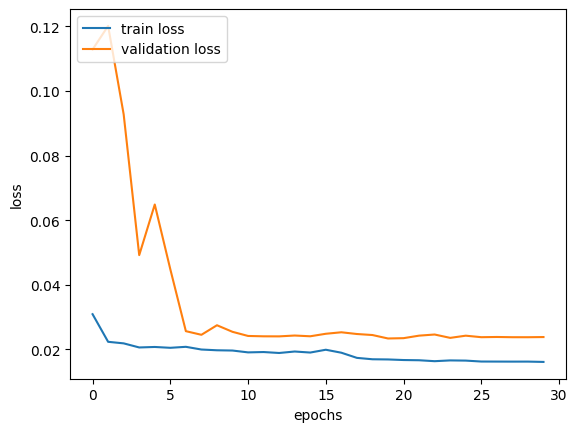

In [47]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
X_val[0][-1].shape

(53, 3, 84, 65, 1)

In [ ]:
x_example_val = [X_val[0][-1], X_val[1][-1]]
x_example_val[0].shape

(3, 84, 65, 1)

In [ ]:
np.expand_dims(x_example_val[1])

(3, 84, 65, 1)

In [ ]:
x_example_val_0 = np.expand_dims(X_val[0][-1], axis=0)
x_example_val_1 = np.expand_dims(X_val[1][-1], axis=0)

In [ ]:
%%time
y_prediction_ = model.predict([x_example_val_0, x_example_val_1])
y_prediction_.shape

1/1 [==============================] - 1s 1s/step
CPU times: user 1.31 s, sys: 9.02 ms, total: 1.32 s
Wall time: 1.31 s


(1, 3, 84, 65, 1)

In [ ]:
y_prediction = np.squeeze(y_prediction_, axis=0)
y_prediction.shape

(3, 84, 65, 1)

In [ ]:
y_example_val = y_val[-1]
y_example_val.shape

(3, 84, 65, 1)

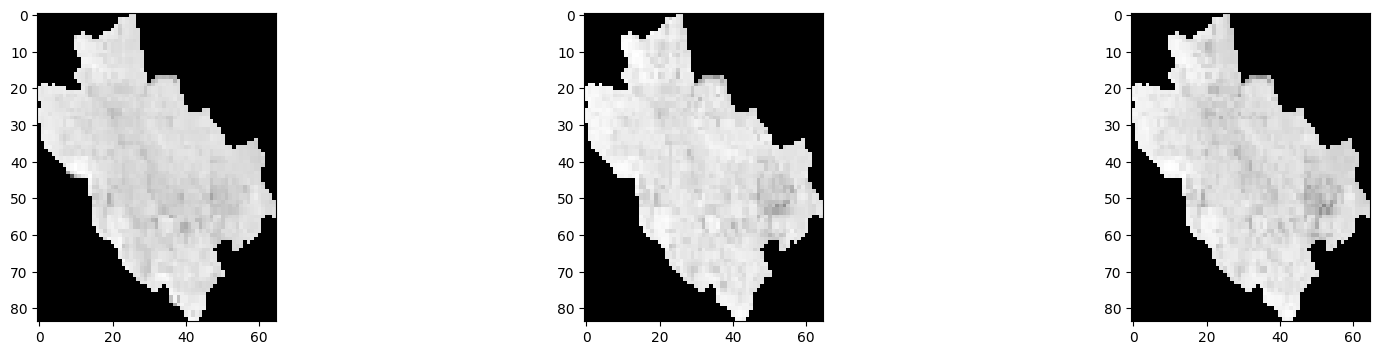

In [ ]:
fig = plt.figure(figsize= (20, 4))
for i in range (3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.imshow(y_example_val[i], cmap="gray")

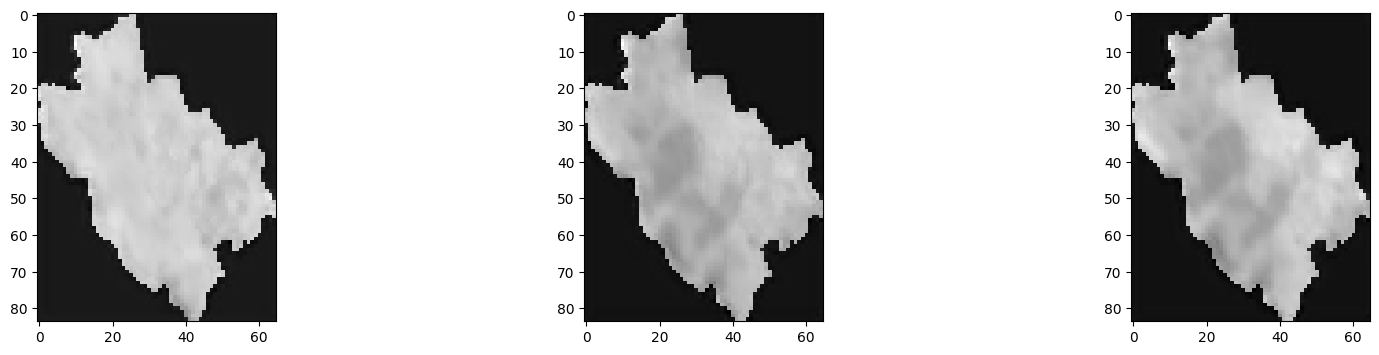

In [ ]:
fig = plt.figure(figsize= (20, 4))
for i in range (3):
  # required nrows=4, required ncoms=4, index_location= i+1
  ax = fig.add_subplot(1, 3, i+1)
  # x_batch[i]: Image object at each iteration
  ax.imshow(y_prediction[i], cmap="gray")

- Model size: 17.2 MB
- Train loss: 0.0165
- Val loss: 0.02340